In [1]:
import pyspark
import dxpy
import dxdata
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import countDistinct, count

ModuleNotFoundError: No module named 'pyspark'

# load the dataset

In [9]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

dispensed_database_name = dxpy.find_one_data_object(
    classname="database", name="app*", folder="/", name_mode="glob", describe=True
)["describe"]["name"]
dispensed_dataset_id = dxpy.find_one_data_object(
    typename="Dataset", name="app*.dataset", folder="/", name_mode="glob"
)["id"]

spark.sql("USE " + dispensed_database_name)

dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [10]:
# Init pyspark and load dataframe
OMOP_TABLE = "omop_drug_era"  # 'omop_drug_era', 'omop_drug_exposure'

# Load dose era table
ode = dataset[OMOP_TABLE]

field_names = [f.name for f in ode.fields]

df = ode.retrieve_fields(names=field_names, engine=dxdata.connect())
# df = df.drop("eid")

print(f"Number of entries {df.count()}")
df.show(5)

Number of entries 19959413
+-------+-------------+---------------+-------------------+-----------------+-------------------+--------+
|    eid|  drug_era_id|drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|
+-------+-------------+---------------+-------------------+-----------------+-------------------+--------+
|6021257|1236950609195|       19005129|         12/05/2014|       10/06/2014|                  1|       0|
|3832658| 798863919105|         743670|         30/03/2011|       02/09/2011|                  5|      12|
|3430966| 721554547993|       19008994|         12/10/2010|       07/11/2010|                  1|       0|
|2127268| 910533073010|         755695|         23/10/2006|       04/10/2007|                  6|      23|
|5185705| 317827646206|       19010400|         30/07/1999|       28/08/1999|                  1|       0|
+-------+-------------+---------------+-------------------+-----------------+-------------------+--------+
only showi

In [11]:
drug_era_atc_pandas = pd.read_csv("drug_era_atc.tsv", sep="\t")
drug_era_atc_pandas.rename(columns={"_c13": "atc_code"}, inplace=True)

In [12]:
drug_era_atc_df = spark.createDataFrame(drug_era_atc_pandas)

df_with_atc = df.join(drug_era_atc_df, on="drug_concept_id", how="left")

# Step 4: Select relevant columns
df_with_atc = df_with_atc.select(
    df.columns + ["concept_name"] + ["atc_code"]
)  # Keep all original columns and add '_c13' (ATC code)
print(f"Number of entries {df_with_atc.count()}")
df_with_atc.show()

/cluster/spark/python/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


Number of entries 41473278
+-------+-------------+---------------+-------------------+-----------------+-------------------+--------+--------------------+--------+
|    eid|  drug_era_id|drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|        concept_name|atc_code|
+-------+-------------+---------------+-------------------+-----------------+-------------------+--------+--------------------+--------+
|1635183|1254130541458|         529303|         28/09/2007|       27/10/2007|                  1|       0|diphtheria toxoid...| J07AF01|
|5613508| 755914269647|         529411|         26/02/1993|       27/03/1993|                  1|       0|tetanus toxoid va...| J07AM01|
|2798830|1391569414591|         929887|         27/08/2014|       15/02/2016|                  9|      64|        lansoprazole| A02BC03|
|4678871|1116691539425|         989878|         26/04/2016|       25/05/2016|                  1|       0|           lidocaine| C01BB01|
|4678871|11166

In [56]:
unique_drug_concepts = df.select("drug_concept_id").distinct().count()
unique_drug_concepts

1620

In [58]:
unique_mapped_drug_concepts = (
    df_with_atc.filter(df_with_atc.atc_code.isNotNull())
    .select("drug_concept_id")
    .distinct()
    .count()
)
print(
    f"Number of unique drug_concept_ids mapped to ATC codes: {unique_mapped_drug_concepts}"
)

Number of unique drug_concept_ids mapped to ATC codes: 1141


# times

In [6]:
drug_usage_unsorted = df.groupBy("drug_concept_id").count()
drug_usage = drug_usage_unsorted.orderBy("count", ascending=False)
drug_usage = drug_usage.withColumnRenamed("count", "times_taken")
drug_usage.show()

+---------------+-----------+
|drug_concept_id|times_taken|
+---------------+-----------+
|        1112807|     927199|
|        1125315|     712882|
|        1713332|     555088|
|        1201620|     406766|
|        1115572|     378066|
|        1501700|     365952|
|        1154343|     361312|
|        1548195|     340392|
|         975125|     334357|
|        1539403|     333229|
|         923645|     308227|
|        1124300|     295240|
|        1177480|     285382|
|         929887|     278990|
|         710062|     242338|
|        1314002|     241296|
|         920458|     223051|
|        1149380|     188009|
|        1521369|     187612|
|        1338005|     181953|
+---------------+-----------+
only showing top 20 rows



In [8]:
drug_usage_pandas = drug_usage.toPandas()

In [126]:
# Use describe() to display a summary of statistics for 'times_taken'
statistics_drug_times = drug_usage_pandas["times_taken"].describe()
print(statistics_drug_times)

count      1620.000000
mean      12320.625309
std       48440.125961
min           1.000000
25%          13.000000
50%         312.500000
75%        4012.500000
max      927199.000000
Name: times_taken, dtype: float64


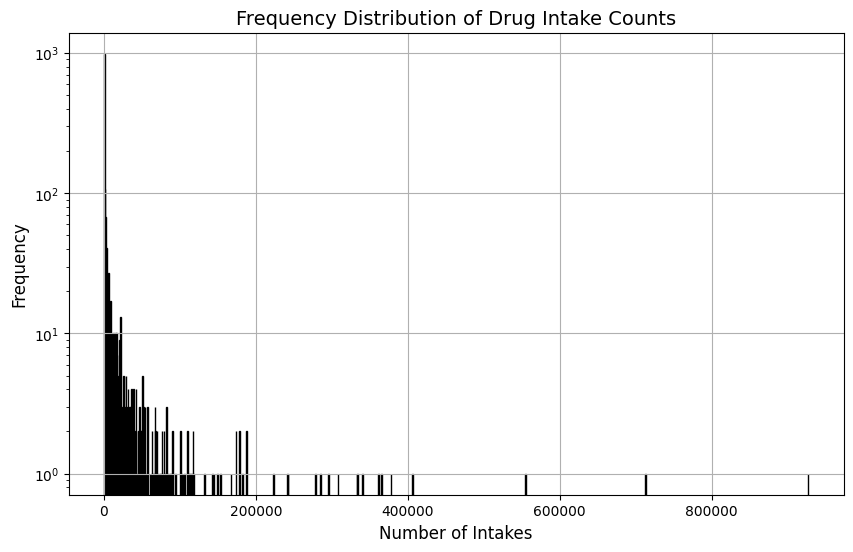

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(drug_usage_pandas["times_taken"], bins=1000, color="blue", edgecolor="black")
plt.title("Frequency Distribution of Drug Intake Counts", fontsize=14)
plt.xlabel("Number of Intakes", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.yscale("log")
plt.show()

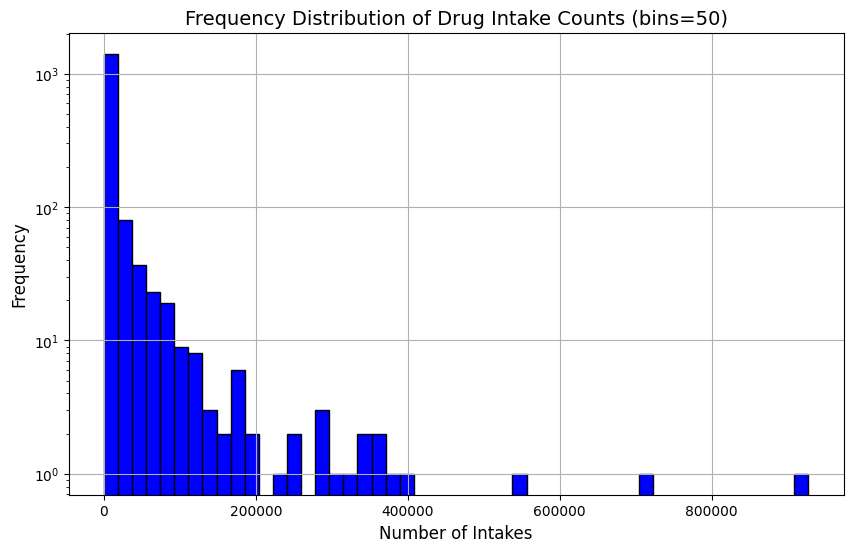

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(drug_usage_pandas["times_taken"], bins=50, color="blue", edgecolor="black")
plt.title("Frequency Distribution of Drug Intake Counts (bins=50)", fontsize=14)
plt.xlabel("Number of Intakes", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.yscale("log")
plt.show()

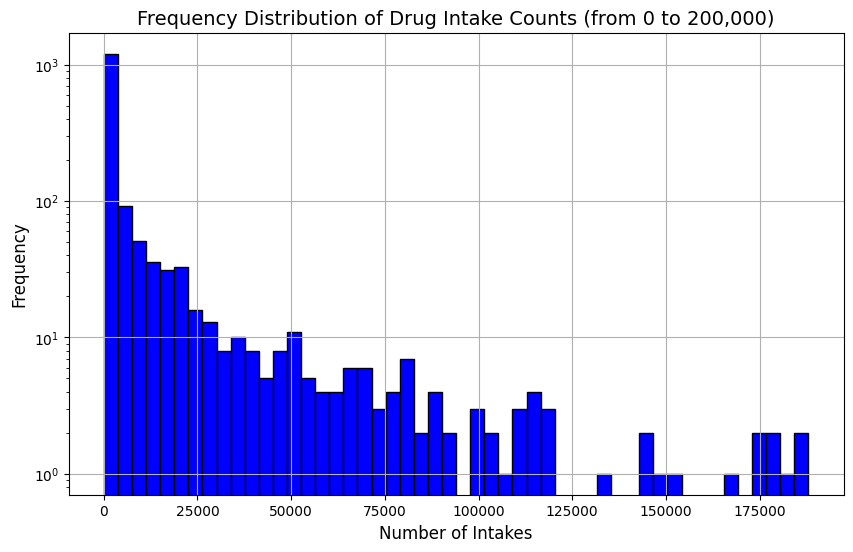

In [87]:
filtered_drug_usage = drug_usage_pandas[
    drug_usage_pandas["times_taken"].between(0, 200000)
]
plt.figure(figsize=(10, 6))
plt.hist(filtered_drug_usage["times_taken"], bins=50, color="blue", edgecolor="black")
plt.title(
    "Frequency Distribution of Drug Intake Counts (from 0 to 200,000)", fontsize=14
)
plt.xlabel("Number of Intakes", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.yscale("log")
plt.show()

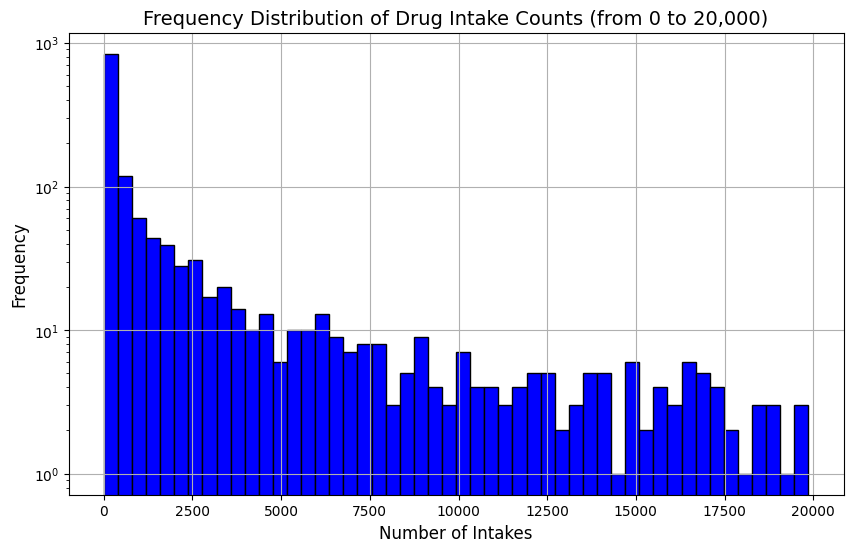

In [88]:
filtered_drug_usage = drug_usage_pandas[
    drug_usage_pandas["times_taken"].between(0, 20000)
]
plt.figure(figsize=(10, 6))
plt.hist(filtered_drug_usage["times_taken"], bins=50, color="blue", edgecolor="black")
plt.title(
    "Frequency Distribution of Drug Intake Counts (from 0 to 20,000)", fontsize=14
)
plt.xlabel("Number of Intakes", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.yscale("log")
plt.show()

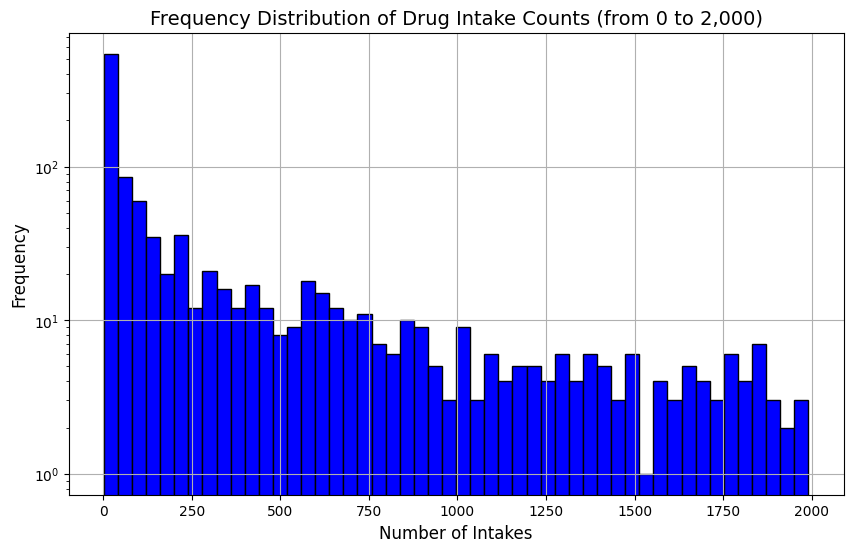

In [89]:
filtered_drug_usage = drug_usage_pandas[
    drug_usage_pandas["times_taken"].between(0, 2000)
]
plt.figure(figsize=(10, 6))
plt.hist(filtered_drug_usage["times_taken"], bins=50, color="blue", edgecolor="black")
plt.title("Frequency Distribution of Drug Intake Counts (from 0 to 2,000)", fontsize=14)
plt.xlabel("Number of Intakes", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.yscale("log")
plt.show()

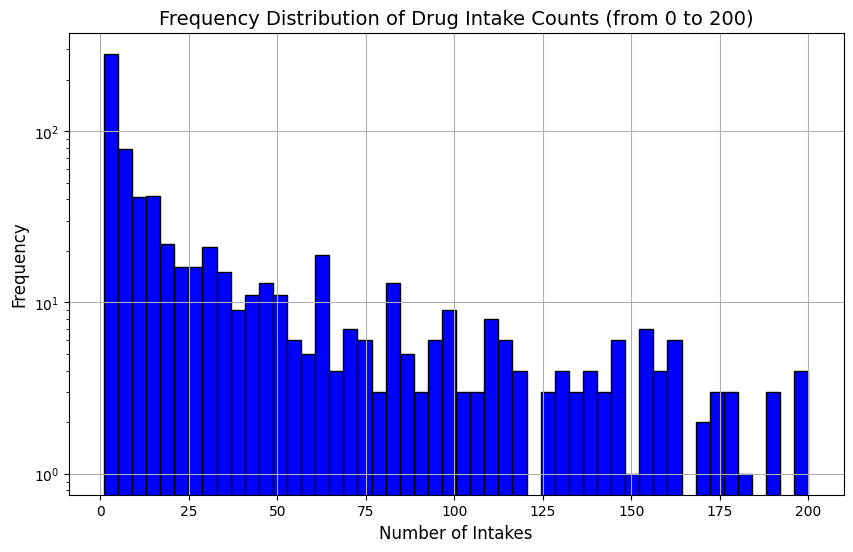

In [90]:
filtered_drug_usage = drug_usage_pandas[
    drug_usage_pandas["times_taken"].between(0, 200)
]
plt.figure(figsize=(10, 6))
plt.hist(filtered_drug_usage["times_taken"], bins=50, color="blue", edgecolor="black")
plt.title("Frequency Distribution of Drug Intake Counts (from 0 to 200)", fontsize=14)
plt.xlabel("Number of Intakes", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.yscale("log")
plt.show()

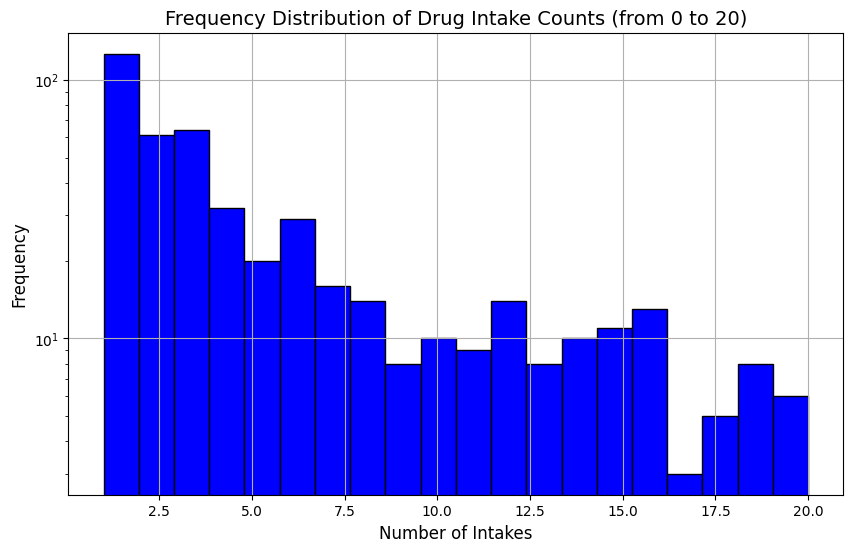

In [95]:
filtered_drug_usage = drug_usage_pandas[drug_usage_pandas["times_taken"].between(0, 20)]
plt.figure(figsize=(10, 6))
plt.hist(filtered_drug_usage["times_taken"], bins=20, color="blue", edgecolor="black")
plt.title("Frequency Distribution of Drug Intake Counts (from 0 to 20)", fontsize=14)
plt.xlabel("Number of Intakes", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.yscale("log")
plt.show()

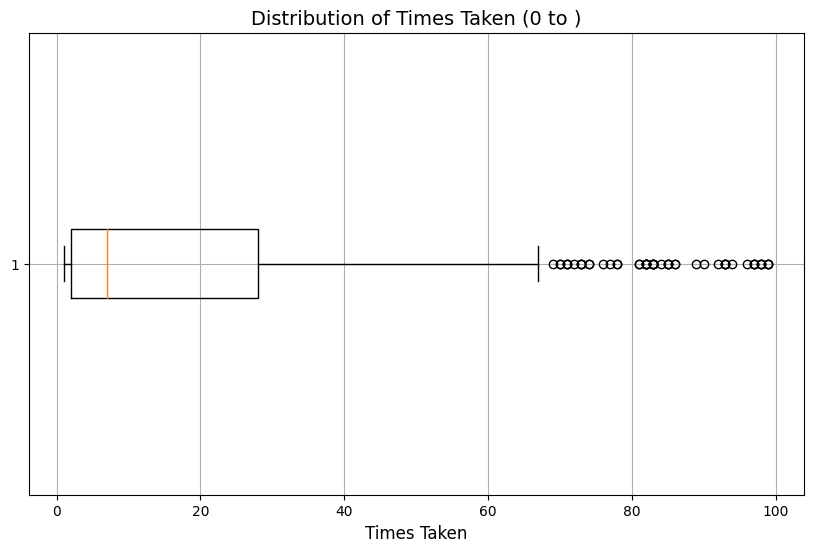

In [81]:
filtered_drug_usage = drug_usage_pandas[
    drug_usage_pandas["times_taken"].between(0, 100)
]
plt.figure(figsize=(10, 6))
plt.boxplot(filtered_drug_usage["times_taken"], vert=False)
plt.title("Distribution of Times Taken (0 to )", fontsize=14)
plt.xlabel("Times Taken", fontsize=12)
plt.grid(True)
plt.show()

In [66]:
# Find drugs taken only once
drugs_taken_once = drug_usage.filter(drug_usage.times_taken == 1)
count_drugs_taken_once = drugs_taken_once.count()
count_drugs_taken_once

126

In [9]:
top_100_drugs_times = (
    drug_usage_pandas.sort_values(by="times_taken", ascending=False)
    .head(100)
    .reset_index(drop=True)
)
bottom_drugs_times = (
    drug_usage_pandas.sort_values(by="times_taken", ascending=True)
    .head(126)
    .reset_index(drop=True)
)

print("Top 100 drugs by times taken:")
print(top_100_drugs_times)

print("\nBottom 126 drugs by times taken:")
print(bottom_drugs_times)

Top 100 drugs by times taken:
   drug_concept_id  times_taken
0          1112807       927199
1          1125315       712882
2          1713332       555088
3          1201620       406766
4          1115572       378066
..             ...          ...
95         1741309        51969
96          902251        51217
97          939259        50938
98         1336926        50668
99        19037989        50619

[100 rows x 2 columns]

Bottom 126 drugs by times taken:
    drug_concept_id  times_taken
0          42873638            1
1            949453            1
2          36878602            1
3           1727443            1
4          19089810            1
..              ...          ...
121         1714165            1
122        35606631            1
123        42903427            1
124        44785885            1
125        43532347            1

[126 rows x 2 columns]


In [10]:
top_100_ids = top_100_drugs_times["drug_concept_id"].tolist()
filtered_df_with_atc = df_with_atc.filter(df_with_atc.drug_concept_id.isin(top_100_ids))
filtered_df_with_atc_pandas = filtered_df_with_atc.select(
    "drug_concept_id", "concept_name", "atc_code"
).toPandas()
top_100_with_info = top_100_drugs_times.merge(
    filtered_df_with_atc_pandas, on="drug_concept_id", how="left"
)
top_100_with_info = top_100_with_info.drop_duplicates().reset_index(drop=True)
print(top_100_with_info)

NameError: name 'df_with_atc' is not defined

In [ ]:
# 1501700	levothyroxine	H03AA01

In [70]:
bottom_drugs_ids = bottom_drugs_times["drug_concept_id"].tolist()
filtered_df_with_atc = df_with_atc.filter(
    df_with_atc.drug_concept_id.isin(bottom_drugs_ids)
)
filtered_df_with_atc_pandas = filtered_df_with_atc.select(
    "drug_concept_id", "concept_name", "atc_code"
).toPandas()
bottom_drugs_with_info = bottom_drugs_times.merge(
    filtered_df_with_atc_pandas, on="drug_concept_id", how="left"
)
bottom_drugs_with_info = bottom_drugs_with_info.drop_duplicates()
print(bottom_drugs_with_info)

    drug_concept_id  times_taken                  concept_name atc_code
0          42873638            1                   carfilzomib  L01XG02
1          19077143            1  17-alpha-hydroxyprogesterone  G03DA03
2          19098741            1               levobupivacaine  N01BB10
3          45892883            1                   secukinumab  L04AC10
4           1758536            1                    etravirine  J05AG04
..              ...          ...                           ...      ...
141          753626            1                      propofol  N01AX10
142        19043833            1                     xamoterol  C01CX07
143        19018416            1                   niclosamide  P02DA01
144          712757            1                   amobarbital  N05CA02
145        19135931            1           cyanocobalamin Co57  V09XX01

[146 rows x 4 columns]


# people

In [108]:
unique_eids = df.select("eid").distinct().count()
unique_eids

281690

In [11]:
drug_people_count_unsorted = df.groupBy("drug_concept_id").agg(
    countDistinct("eid").alias("unique_people_count")
)
drug_people_count = drug_people_count_unsorted.orderBy(
    "unique_people_count", ascending=False
)
print(f"Number of entries {drug_people_count.count()}")
drug_people_count.show()

Number of entries 1620
+---------------+-------------------+
|drug_concept_id|unique_people_count|
+---------------+-------------------+
|        1713332|             141912|
|        1125315|             116112|
|         975125|             108940|
|        1201620|             102314|
|        1124300|              95165|
|        1177480|              93572|
|       19054936|              89222|
|         923645|              82127|
|         920458|              71320|
|        1705674|              67857|
|        1115008|              66203|
|         929887|              62879|
|        1539403|              62098|
|       19010400|              61557|
|       35200165|              61139|
|        1115572|              60639|
|        1000632|              57668|
|         529411|              57031|
|         990069|              50617|
|        1746940|              50136|
+---------------+-------------------+
only showing top 20 rows



In [12]:
drug_people_count_pandas = drug_people_count.toPandas()

In [129]:
statistics_drug_people = drug_people_count_pandas["unique_people_count"].describe()
print(statistics_drug_people)

count      1620.000000
mean       3674.214815
std       11299.932931
min           1.000000
25%           7.000000
50%         121.000000
75%        1411.500000
max      141912.000000
Name: unique_people_count, dtype: float64


In [141]:
# Find drugs taken only by one person
drugs_taken_one_person = drug_people_count.filter(
    drug_people_count.unique_people_count == 1
)
count_drugs_taken_one_person = drugs_taken_one_person.count()
count_drugs_taken_one_person

157

In [16]:
people_top_100_drugs = (
    drug_people_count_pandas.sort_values(by="unique_people_count", ascending=False)
    .head(100)
    .reset_index(drop=True)
)
people_top_100_drugs.to_csv("people_top_100_drugs.csv", index=False)

In [17]:
people_bottom_157_drugs = (
    drug_people_count_pandas.sort_values(by="unique_people_count", ascending=True)
    .head(157)
    .reset_index(drop=True)
)
people_bottom_157_drugs.to_csv("people_bottom_157_drugs.csv", index=False)

In [136]:
drug_usage_pandas.to_csv("drug_times_count.csv", index=False)

In [137]:
drug_people_count_pandas.to_csv("drug_people_count.csv", index=False)

In [47]:
top_100_drugs_times.to_csv("times_top_100.csv", index=False)

In [140]:
bottom_drugs_with_info.to_csv("times_bottom_126.csv", index=False)

In [48]:
top_100_drugs_times["drug_concept_id"] = top_100_drugs_times["drug_concept_id"].astype(
    int
)

times_top_100_with_info = top_100_drugs_times.merge(
    drug_era_atc_pandas[["drug_concept_id", "concept_name", "atc_code"]],
    on="drug_concept_id",
    how="left",
)

print(times_top_100_with_info)
times_top_100_with_info.to_csv("times_top_100_with_info.csv", index=False)

     drug_concept_id  times_taken   concept_name atc_code
0            1112807       927199        aspirin  A01AD05
1            1112807       927199        aspirin  B01AC06
2            1112807       927199        aspirin  N02BA01
3            1125315       712882  acetaminophen  N02BE01
4            1713332       555088    amoxicillin  J01CA04
..               ...          ...            ...      ...
218           939259        50938     budesonide  D07AC09
219           939259        50938     budesonide  R01AD05
220           939259        50938     budesonide  R03BA02
221          1336926        50668      tadalafil  G04BE08
222         19037989        50619      dothiepin  N06AA16

[223 rows x 4 columns]


In [23]:
people_top_100_drugs["drug_concept_id"] = people_top_100_drugs[
    "drug_concept_id"
].astype(int)

people_top_100_drugs_with_info = people_top_100_drugs.merge(
    drug_era_atc_pandas[["drug_concept_id", "concept_name", "atc_code"]],
    on="drug_concept_id",
    how="left",
)

print(people_top_100_drugs_with_info)
people_top_100_drugs_with_info.to_csv("people_top_100_drugs_with_info.csv", index=False)

     drug_concept_id  unique_people_count    concept_name atc_code
0            1713332               141912     amoxicillin  J01CA04
1            1125315               116112   acetaminophen  N02BE01
2             975125               108940  hydrocortisone  A01AC03
3             975125               108940  hydrocortisone  A07EA02
4             975125               108940  hydrocortisone  C05AA01
..               ...                  ...             ...      ...
227          1146810                17736       piroxicam  S01BC06
228          1353766                17717     propranolol  C07AA05
229          1153664                16642    propoxyphene  N02AC04
230          1316262                16161      sildenafil  G04BE03
231         40798976                16035             NaN      NaN

[232 rows x 4 columns]


In [26]:
people_bottom_157_drugs["drug_concept_id"] = people_bottom_157_drugs[
    "drug_concept_id"
].astype(int)

people_bottom_157_drugs_with_info = people_bottom_157_drugs.merge(
    drug_era_atc_pandas[["drug_concept_id", "concept_name", "atc_code"]],
    on="drug_concept_id",
    how="left",
)

print(people_bottom_157_drugs_with_info)
people_bottom_157_drugs_with_info.to_csv(
    "people_bottom_157_drugs_with_info.csv", index=False
)

     drug_concept_id  unique_people_count           concept_name atc_code
0             908360                    1             magaldrate  A02AD02
1           42900351                    1                    NaN      NaN
2           46287466                    1             evolocumab  C10AX13
3           19036781                    1       calcium chloride  A12AA07
4           19036781                    1       calcium chloride  B05XA07
..               ...                  ...                    ...      ...
172          1336825                    1             bortezomib  L01XG01
173          1714165                    1  peginterferon alfa-2a  L03AB11
174         19136187                    1          streptokinase  B01AD01
175         19100393                    1                    NaN      NaN
176          1310353                    1                    NaN      NaN

[177 rows x 4 columns]


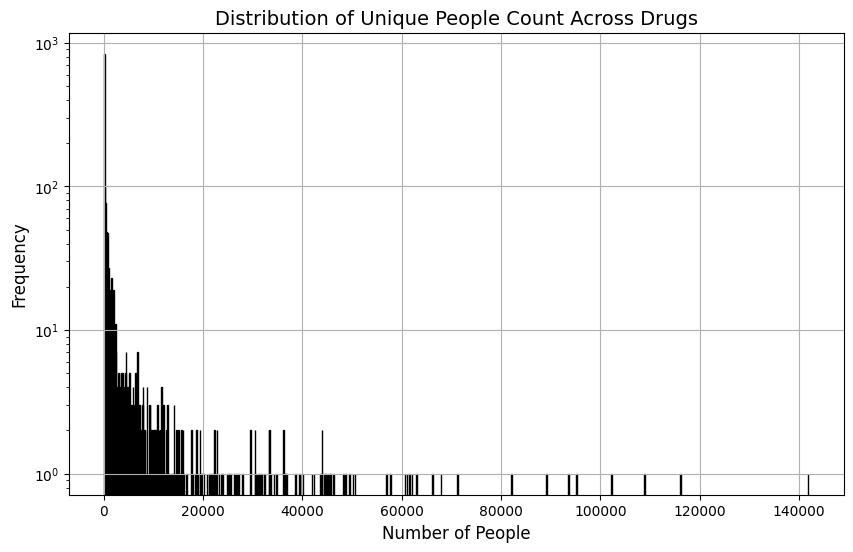

In [40]:
plt.figure(figsize=(10, 6))
plt.hist(
    drug_people_count_pandas["unique_people_count"],
    bins=1000,
    color="blue",
    edgecolor="black",
)
plt.title("Distribution of Unique People Count Across Drugs", fontsize=14)
plt.xlabel("Number of People", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.yscale("log")
plt.show()

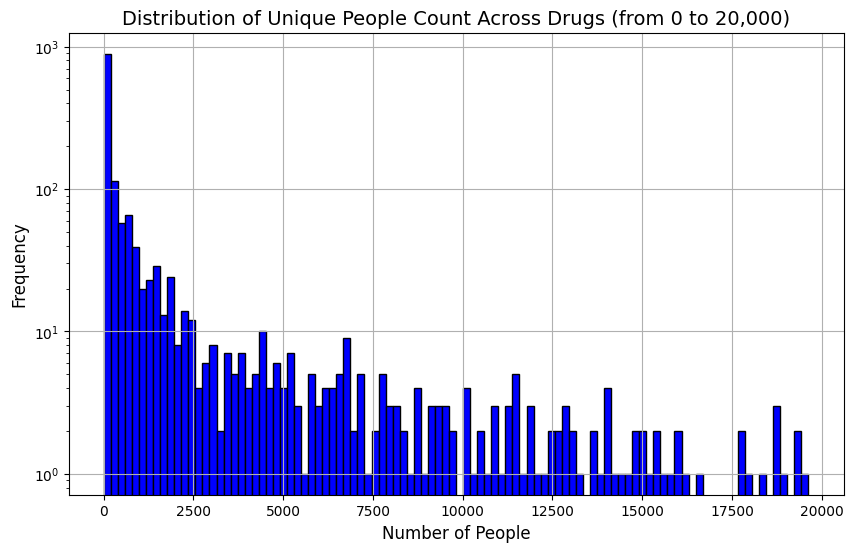

In [41]:
filtered_drug_people = drug_people_count_pandas[
    drug_people_count_pandas["unique_people_count"].between(0, 20000)
]
plt.figure(figsize=(10, 6))
plt.hist(
    filtered_drug_people["unique_people_count"],
    bins=100,
    color="blue",
    edgecolor="black",
)
plt.title(
    "Distribution of Unique People Count Across Drugs (from 0 to 20,000)", fontsize=14
)
plt.xlabel("Number of People", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.yscale("log")
plt.show()

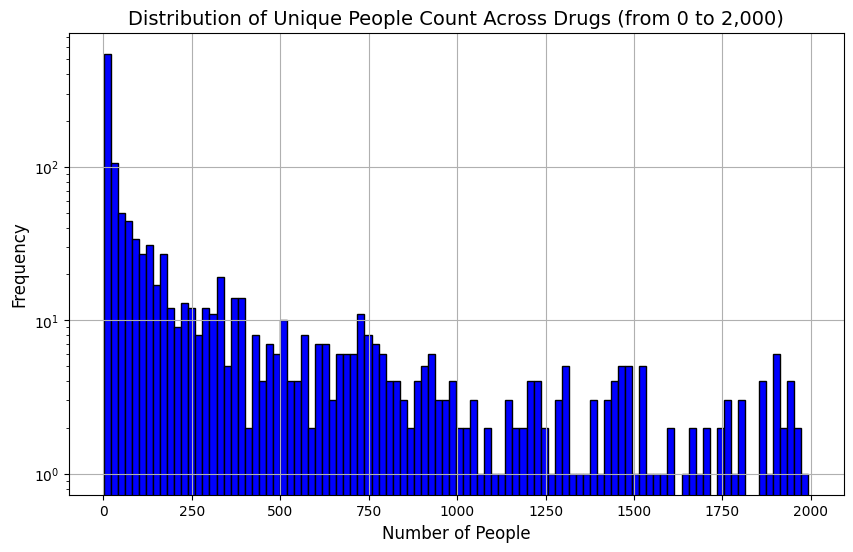

In [42]:
filtered_drug_people = drug_people_count_pandas[
    drug_people_count_pandas["unique_people_count"].between(0, 2000)
]
plt.figure(figsize=(10, 6))
plt.hist(
    filtered_drug_people["unique_people_count"],
    bins=100,
    color="blue",
    edgecolor="black",
)
plt.title(
    "Distribution of Unique People Count Across Drugs (from 0 to 2,000)", fontsize=14
)
plt.xlabel("Number of People", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.yscale("log")
plt.show()

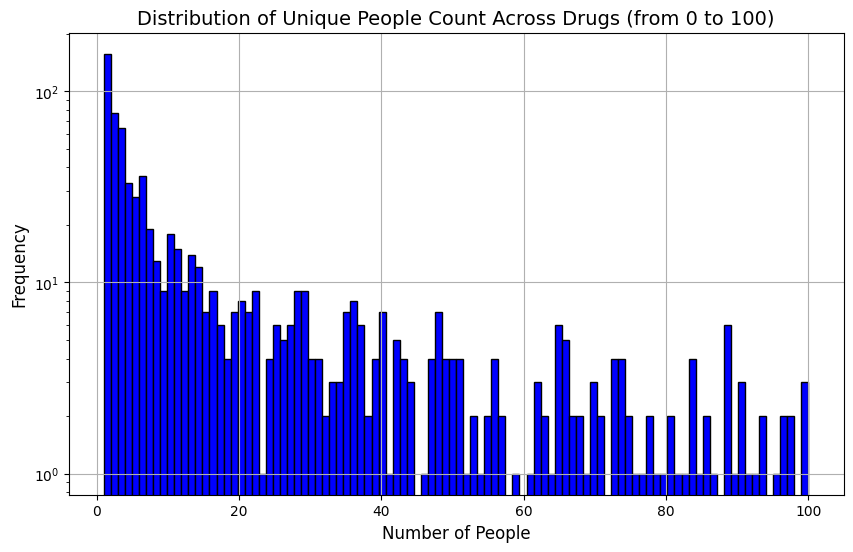

In [44]:
filtered_drug_people = drug_people_count_pandas[
    drug_people_count_pandas["unique_people_count"].between(0, 100)
]
plt.figure(figsize=(10, 6))
plt.hist(
    filtered_drug_people["unique_people_count"],
    bins=100,
    color="blue",
    edgecolor="black",
)
plt.title(
    "Distribution of Unique People Count Across Drugs (from 0 to 100)", fontsize=14
)
plt.xlabel("Number of People", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.yscale("log")
plt.show()

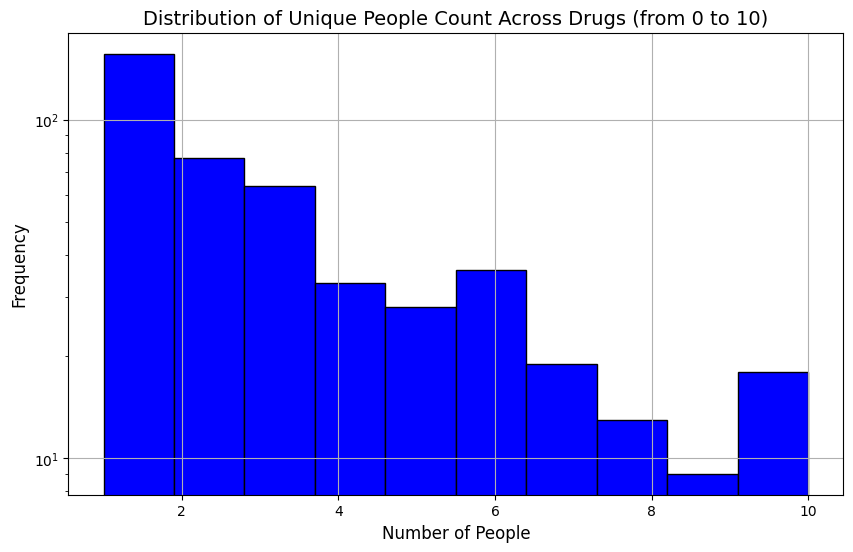

In [45]:
filtered_drug_people = drug_people_count_pandas[
    drug_people_count_pandas["unique_people_count"].between(0, 10)
]
plt.figure(figsize=(10, 6))
plt.hist(
    filtered_drug_people["unique_people_count"],
    bins=10,
    color="blue",
    edgecolor="black",
)
plt.title(
    "Distribution of Unique People Count Across Drugs (from 0 to 10)", fontsize=14
)
plt.xlabel("Number of People", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.yscale("log")
plt.show()

# times, people

In [13]:
people_times_count = df.groupBy("eid", "drug_concept_id").agg(
    count("*").alias("times_taken")
)
people_times_count = people_times_count.orderBy("times_taken", ascending=False)
people_times_count.show()

+-------+---------------+-----------+
|    eid|drug_concept_id|times_taken|
+-------+---------------+-----------+
|2998435|        1112807|        155|
|1735913|         798874|        153|
|3091011|        1112807|        151|
|1348057|         752061|        151|
|4972777|        1353766|        150|
|2280847|        1112807|        148|
|2133507|        1501700|        148|
|3392854|         734275|        147|
|1207609|        1112807|        146|
|4737000|        1112807|        145|
|5389943|        1112807|        145|
|3414811|        1112807|        145|
|2296486|         740275|        141|
|1043602|        1112807|        141|
|1527948|        1501700|        140|
|3879059|        1539403|        139|
|6014167|        1760616|        139|
|1233544|        1353766|        138|
|3675859|        1112807|        138|
|2635285|        1112807|        138|
+-------+---------------+-----------+
only showing top 20 rows



In [15]:
people_times_count_pandas = people_times_count.toPandas()

In [19]:
statistics_people_times = people_times_count_pandas["times_taken"].describe()
print(statistics_people_times)

count    5.952228e+06
mean     3.353268e+00
std      6.231562e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      1.550000e+02
Name: times_taken, dtype: float64


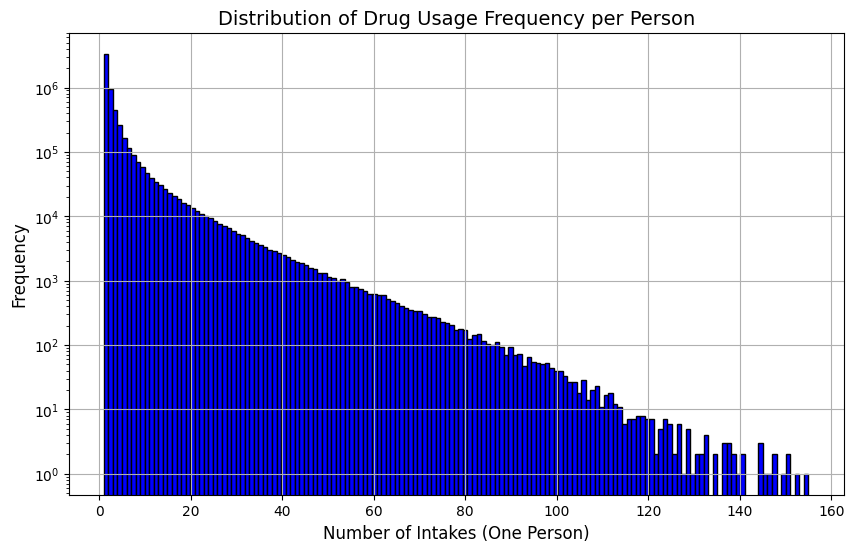

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(
    people_times_count_pandas["times_taken"],
    bins=155,
    color="blue",
    edgecolor="black",
)
plt.title("Distribution of Drug Usage Frequency per Person", fontsize=14)
plt.xlabel("Number of Intakes (One Person)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.yscale("log")
plt.show()

# people, drug variety

In [33]:
people_drug_variety_unsorted = df.groupBy("eid").agg(
    countDistinct("drug_concept_id").alias("distinct_drugs_taken")
)
people_drug_variety = people_drug_variety_unsorted.orderBy(
    "distinct_drugs_taken", ascending=False
)
people_drug_variety.show()

+-------+--------------------+
|    eid|distinct_drugs_taken|
+-------+--------------------+
|5030277|                 218|
|5507704|                 209|
|1710016|                 208|
|5606096|                 202|
|2749554|                 201|
|3509269|                 191|
|4179944|                 187|
|1969086|                 178|
|3110755|                 177|
|2676712|                 177|
|5303223|                 177|
|3071248|                 177|
|4212426|                 177|
|3449265|                 175|
|5223931|                 174|
|1836915|                 173|
|4837119|                 173|
|1907472|                 172|
|2131839|                 171|
|2748222|                 168|
+-------+--------------------+
only showing top 20 rows



In [34]:
people_drug_variety_pandas = people_drug_variety.toPandas()

In [35]:
people_drug_variety_pandas_no_eid = people_drug_variety_pandas.drop("eid", axis=1)

In [36]:
people_drug_variety_pandas_no_eid.to_csv("people_drug_variety.csv", index=False)

In [24]:
statistics_people_drug_variety = people_drug_variety_pandas[
    "distinct_drugs_taken"
].describe()
print(statistics_people_drug_variety)

count    281690.000000
mean         21.130420
std          19.369678
min           1.000000
25%           5.000000
50%          17.000000
75%          31.000000
max         218.000000
Name: distinct_drugs_taken, dtype: float64


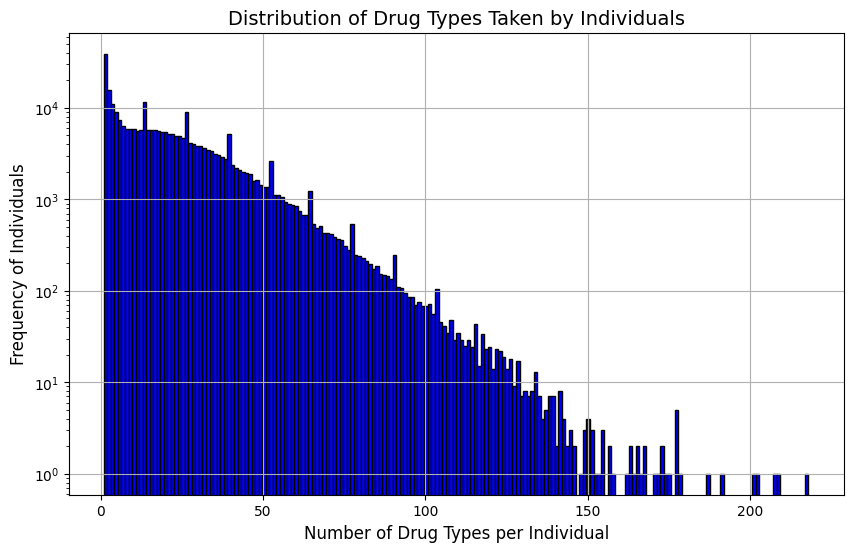

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(
    people_drug_variety_pandas["distinct_drugs_taken"],
    bins=200,
    color="blue",
    edgecolor="black",
)
plt.title("Distribution of Drug Types Taken by Individuals", fontsize=14)
plt.xlabel("Number of Drug Types per Individual", fontsize=12)
plt.ylabel("Frequency of Individuals", fontsize=12)
plt.grid(True)
plt.yscale("log")
plt.show()

In [45]:
variety_218_drugs = df.filter(df.eid == 5030277).select("drug_concept_id").distinct()
variety_218_drugs_pandas = variety_218_drugs.toPandas()
variety_218_drugs_pandas.to_csv("variety_218_drugs.csv", index=False)

In [51]:
variety_209_drugs = df.filter(df.eid == 5507704).select("drug_concept_id").distinct()
variety_209_drugs_pandas = variety_209_drugs.toPandas()
variety_209_drugs_pandas.to_csv("variety_209_drugs.csv", index=False)

In [50]:
variety_208_drugs = df.filter(df.eid == 1710016).select("drug_concept_id").distinct()
variety_208_drugs_pandas = variety_208_drugs.toPandas()
variety_208_drugs_pandas.to_csv("variety_208_drugs.csv", index=False)

In [53]:
variety_202_drugs = df.filter(df.eid == 5606096).select("drug_concept_id").distinct()
variety_202_drugs_pandas = variety_202_drugs.toPandas()
variety_202_drugs_pandas.to_csv("variety_202_drugs.csv", index=False)

In [54]:
variety_201_drugs = df.filter(df.eid == 2749554).select("drug_concept_id").distinct()
variety_201_drugs_pandas = variety_201_drugs.toPandas()
variety_201_drugs_pandas.to_csv("variety_201_drugs.csv", index=False)

local

In [2]:
import pandas as pd

In [34]:
variety_218_drugs = pd.read_csv("variety_218_drugs.csv")
variety_209_drugs = pd.read_csv("variety_209_drugs.csv")
variety_208_drugs = pd.read_csv("variety_208_drugs.csv")
variety_202_drugs = pd.read_csv("variety_202_drugs.csv")
variety_201_drugs = pd.read_csv("variety_201_drugs.csv")

In [31]:
drug_era_atc_pandas = pd.read_csv(
    "/Users/punny/Repos/Project_PerMed/mappings/drug_era/drug_era_atc.tsv", sep="\t"
)
drug_era_atc_pandas.rename(columns={"_c13": "atc_code"}, inplace=True)

In [33]:
def add_drug_info(df):
    # Convert drug_concept_id to integer if it's not already
    if df["drug_concept_id"].dtype != "int64":
        df["drug_concept_id"] = df["drug_concept_id"].astype("int64")

    # Merge input DataFrame with drug_era_atc_pandas
    output_df = df.merge(
        drug_era_atc_pandas[["drug_concept_id", "concept_name", "atc_code"]],
        on="drug_concept_id",
        how="left",
    )

    return output_df

In [35]:
variety_218_drugs_with_info = add_drug_info(variety_218_drugs)
variety_218_drugs_with_info.to_csv("variety_218_drugs_with_info.csv", index=False)
variety_209_drugs_with_info = add_drug_info(variety_209_drugs)
variety_209_drugs_with_info.to_csv("variety_209_drugs_with_info.csv", index=False)
variety_208_drugs_with_info = add_drug_info(variety_208_drugs)
variety_208_drugs_with_info.to_csv("variety_208_drugs_with_info.csv", index=False)
variety_202_drugs_with_info = add_drug_info(variety_202_drugs)
variety_202_drugs_with_info.to_csv("variety_202_drugs_with_info.csv", index=False)
variety_201_drugs_with_info = add_drug_info(variety_201_drugs)
variety_201_drugs_with_info.to_csv("variety_201_drugs_with_info.csv", index=False)

In [51]:
def analyze_atc_codes(df, atc_column="atc_code", top_n=10, subject=None):
    """
    Analyze ATC codes in a DataFrame and generate charts for 1st and 2nd levels,
    and text output for 3rd and 4th levels.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the ATC codes
    atc_column (str): The name of the column containing ATC codes
    top_n (int): Number of top categories to display for each level
    subject (int): Subject number to include in the plot title

    Returns:
    dict: A dictionary containing DataFrames with counts for each ATC level and figures
    """

    # Extract ATC level 1, 2, 3, and 4 codes
    df["atc_level1"] = df[atc_column].str[:1]
    df["atc_level2"] = df[atc_column].str[:3]
    df["atc_level3"] = df[atc_column].str[:4]
    df["atc_level4"] = df[atc_column].str[:5]

    # ... (existing code for helper functions)

    # Analyze ATC level 1
    level1_counts = df["atc_level1"].value_counts()
    plot_df_level1 = pd.DataFrame(
        {
            "count": level1_counts,
            "category": [get_atc_level1_name(code) for code in level1_counts.index],
        }
    ).sort_values("count", ascending=True)

    # Create ATC level 1 plot
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    plot_df_level1.plot(kind="barh", x="category", y="count", ax=ax1, legend=False)
    title = "ATC Level 1 Categories"
    if subject is not None:
        title += f" (Subject {subject})"
    ax1.set_title(title, fontsize=16)
    ax1.set_xlabel("Number of Drugs", fontsize=12)
    ax1.set_ylabel("ATC Level 1 Category", fontsize=12)
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)

    total_drugs_level1 = plot_df_level1["count"].sum()
    for i, (index, row) in enumerate(plot_df_level1.iterrows()):
        count = row["count"]
        percentage = (count / total_drugs_level1 * 100).round(1)
        ax1.text(count, i, f" {count} ({percentage}%)", va="center", fontsize=10)

    plt.tight_layout()

    # Analyze top N ATC level 2
    level2_counts = df["atc_level2"].value_counts().head(top_n)
    plot_df_level2 = pd.DataFrame(
        {
            "count": level2_counts,
            "category": [get_atc_level2_name(code) for code in level2_counts.index],
        }
    ).sort_values("count", ascending=True)

    # Create ATC level 2 plot
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    plot_df_level2.plot(kind="barh", x="category", y="count", ax=ax2, legend=False)
    title = f"Top {top_n} ATC Level 2 Categories"
    if subject is not None:
        title += f" (Subject {subject})"
    ax2.set_title(title, fontsize=16)
    ax2.set_xlabel("Number of Drugs", fontsize=12)
    ax2.set_ylabel("ATC Level 2 Category", fontsize=12)
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)

    total_drugs_level2 = plot_df_level2["count"].sum()
    for i, (index, row) in enumerate(plot_df_level2.iterrows()):
        count = row["count"]
        percentage = (count / total_drugs_level2 * 100).round(1)
        ax2.text(count, i, f" {count} ({percentage}%)", va="center", fontsize=10)

    plt.tight_layout()

    # Analyze top N ATC level 3 and 4
    level3_counts = df["atc_level3"].value_counts().head(top_n)
    plot_df_level3 = pd.DataFrame(
        {"count": level3_counts, "category": level3_counts.index}
    ).sort_values("count", ascending=False)

    level4_counts = df["atc_level4"].value_counts().head(top_n)
    plot_df_level4 = pd.DataFrame(
        {"count": level4_counts, "category": level4_counts.index}
    ).sort_values("count", ascending=False)

    # Return DataFrames with counts for each level and figures
    return {
        "level1": plot_df_level1,
        "level2": plot_df_level2,
        "level3": plot_df_level3,
        "level4": plot_df_level4,
        "figure1": fig1,
        "figure2": fig2,
    }

In [60]:
def get_atc_level2_name(code):
    # You can expand this dictionary with more ATC level 2 codes and their descriptions
    atc_level2_names = {
        "A01": "Stomatological preparations",
        "A02": "Drugs for acid related disorders",
        "B01": "Antithrombotic agents",
        "C01": "Cardiac therapy",
        # Add more ATC level 2 codes and descriptions as needed
    }
    return atc_level2_names.get(code, f"ATC {code}")


# Add this function definition before using it in the DataFrame creation

In [59]:
def get_atc_level1_name(code):
    atc_level1_names = {
        "A": "Alimentary tract and metabolism",
        "B": "Blood and blood forming organs",
        "C": "Cardiovascular system",
        "D": "Dermatologicals",
        "G": "Genito-urinary system and sex hormones",
        "H": "Systemic hormonal preparations, excluding sex hormones and insulins",
        "J": "Antiinfectives for systemic use",
        "L": "Antineoplastic and immunomodulating agents",
        "M": "Musculo-skeletal system",
        "N": "Nervous system",
        "P": "Antiparasitic products, insecticides and repellents",
        "R": "Respiratory system",
        "S": "Sensory organs",
        "V": "Various",
    }
    return atc_level1_names.get(code, "Unknown")


# Add this function definition before using it in the DataFrame creation


ATC level 1 categories:
            count                                           category
atc_level1                                                          
V               1                                          V Various
L               3       L Antineoplastic and Immunomodulating Agents
P               4  P Antiparasitic Products, Insecticides and Rep...
H               8  H Systemic Hormonal Preparations, Excl. Sex Ho...
B              13                   B Blood and Blood Forming Organs
M              13                          M Musculo-Skeletal System
J              22                  J Antiinfectives for Systemic Use
C              23                            C Cardiovascular System
G              26           G Genito Urinary System and Sex Hormones
N              27                                   N Nervous System
R              33                               R Respiratory System
D              54                                  D Dermatologicals
A        

/var/folders/7w/rj_0j9_94558rkgpj7x7fydh0000gn/T/ipykernel_4599/222674776.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  result['figure1'].show()
/var/folders/7w/rj_0j9_94558rkgpj7x7fydh0000gn/T/ipykernel_4599/222674776.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  result['figure2'].show()


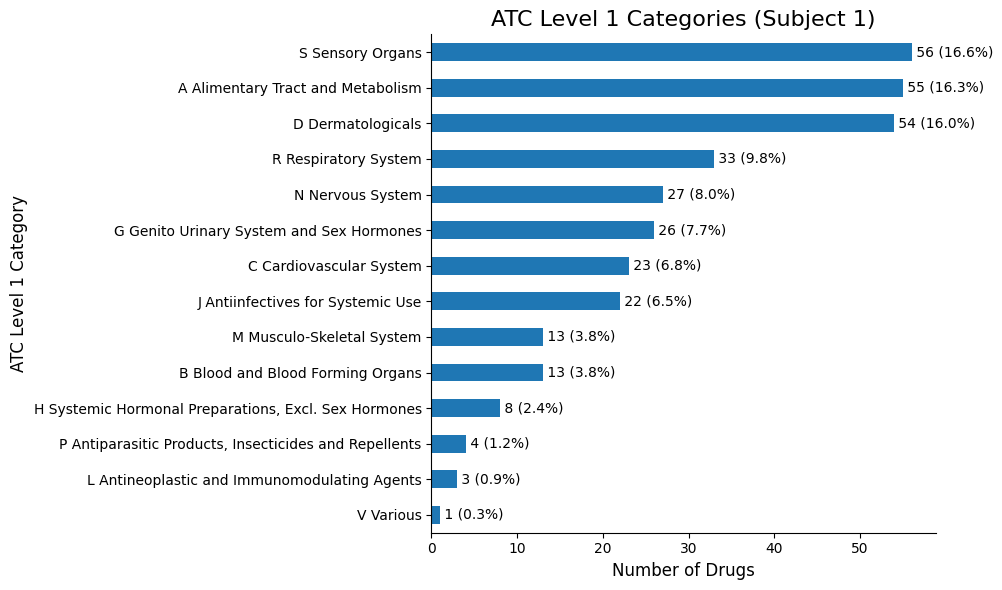

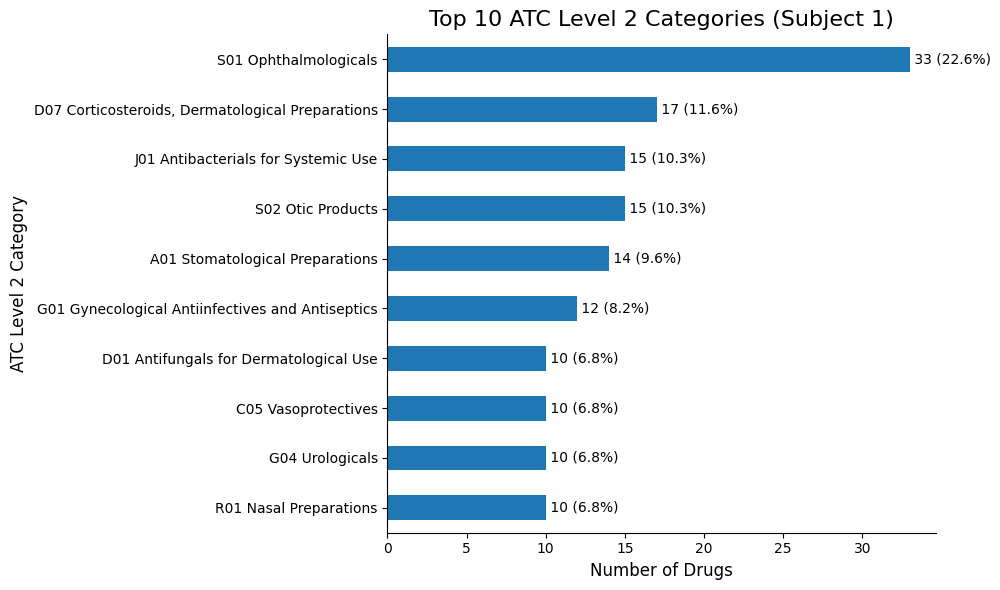

In [53]:
result = analyze_atc_codes(
    variety_218_drugs_with_info, atc_column="atc_code", top_n=10, subject=1
)

print("\nATC level 1 categories:")
print(result["level1"])
print("\nTop 10 ATC level 2 categories:")
print(result["level2"])
print("\nTop 10 ATC level 3 categories:")
print(result["level3"])
print("\nTop 10 ATC level 4 categories:")
print(result["level4"])

# Display the plots
result["figure1"].show()
result["figure2"].show()


ATC level 1 categories:
            count                                           category
atc_level1                                                          
V               4                                          V Various
H               6  H Systemic Hormonal Preparations, Excl. Sex Ho...
L               6       L Antineoplastic and Immunomodulating Agents
P               7  P Antiparasitic Products, Insecticides and Rep...
B              11                   B Blood and Blood Forming Organs
M              17                          M Musculo-Skeletal System
G              20           G Genito Urinary System and Sex Hormones
J              21                  J Antiinfectives for Systemic Use
C              26                            C Cardiovascular System
R              37                               R Respiratory System
D              48                                  D Dermatologicals
S              48                                   S Sensory Organs
N        

/var/folders/7w/rj_0j9_94558rkgpj7x7fydh0000gn/T/ipykernel_4599/1139951589.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  result['figure1'].show()
/var/folders/7w/rj_0j9_94558rkgpj7x7fydh0000gn/T/ipykernel_4599/1139951589.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  result['figure2'].show()


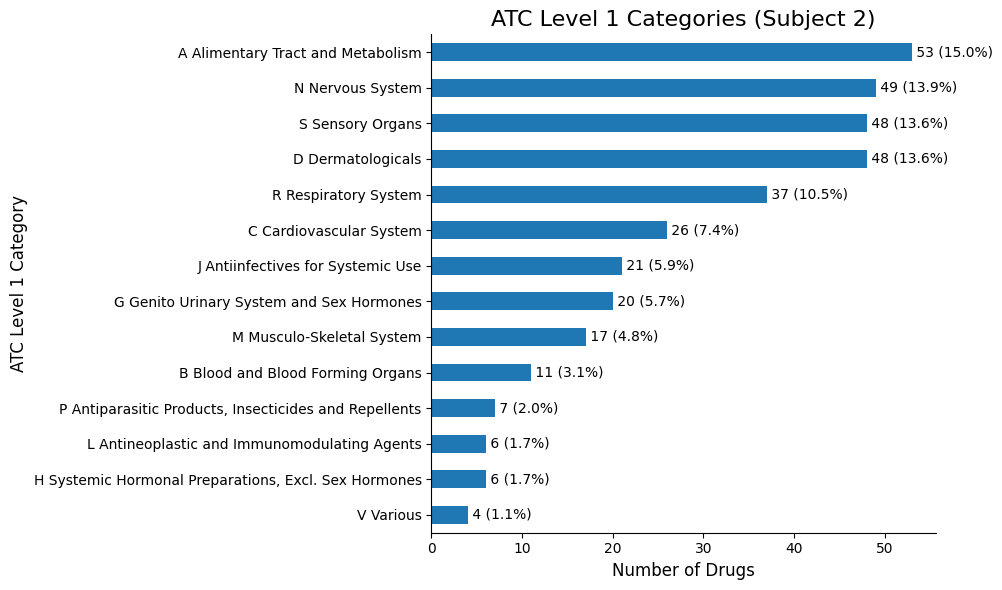

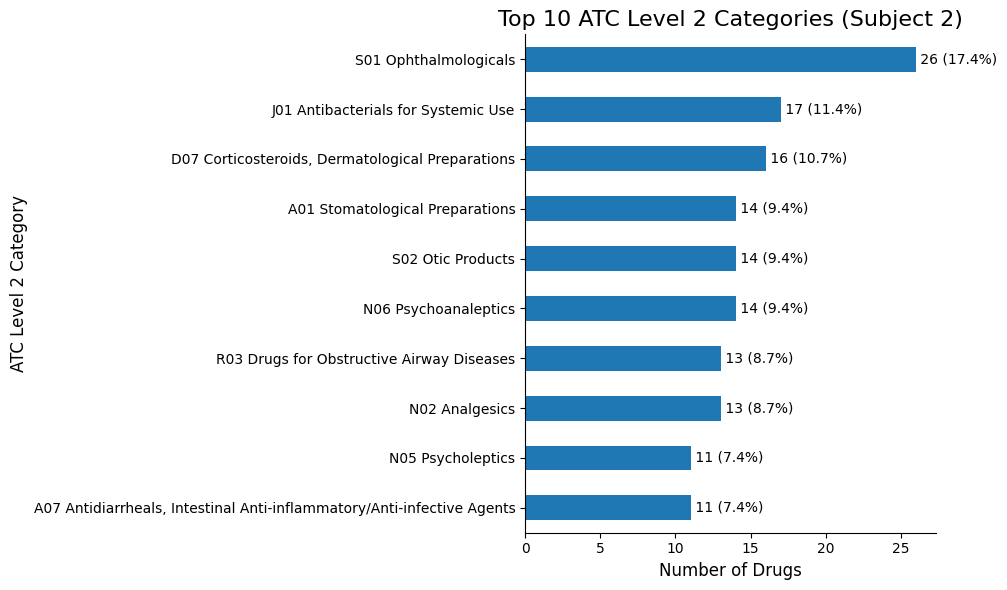

In [54]:
result = analyze_atc_codes(
    variety_209_drugs_with_info, atc_column="atc_code", top_n=10, subject=2
)

print("\nATC level 1 categories:")
print(result["level1"])
print("\nTop 10 ATC level 2 categories:")
print(result["level2"])
print("\nTop 10 ATC level 3 categories:")
print(result["level3"])
print("\nTop 10 ATC level 4 categories:")
print(result["level4"])

# Display the plots
result["figure1"].show()
result["figure2"].show()


ATC level 1 categories:
            count                                           category
atc_level1                                                          
L               1       L Antineoplastic and Immunomodulating Agents
P               3  P Antiparasitic Products, Insecticides and Rep...
V               4                                          V Various
H               7  H Systemic Hormonal Preparations, Excl. Sex Ho...
B              14                   B Blood and Blood Forming Organs
G              15           G Genito Urinary System and Sex Hormones
M              18                          M Musculo-Skeletal System
C              27                            C Cardiovascular System
J              28                  J Antiinfectives for Systemic Use
N              33                                   N Nervous System
R              38                               R Respiratory System
D              47                                  D Dermatologicals
S        

/var/folders/7w/rj_0j9_94558rkgpj7x7fydh0000gn/T/ipykernel_4599/2708291213.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  result["figure1"].show()
/var/folders/7w/rj_0j9_94558rkgpj7x7fydh0000gn/T/ipykernel_4599/2708291213.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  result["figure2"].show()


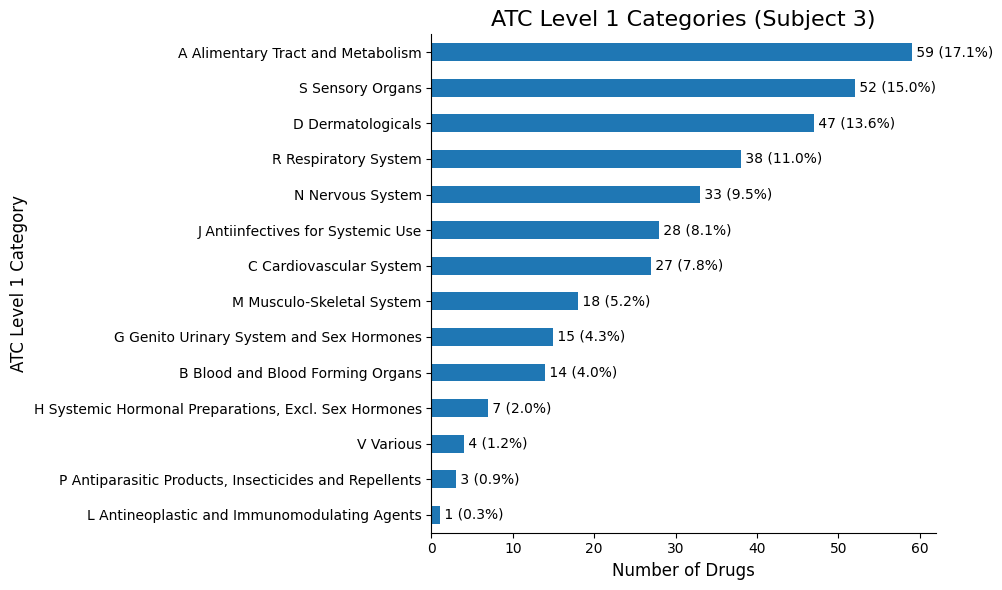

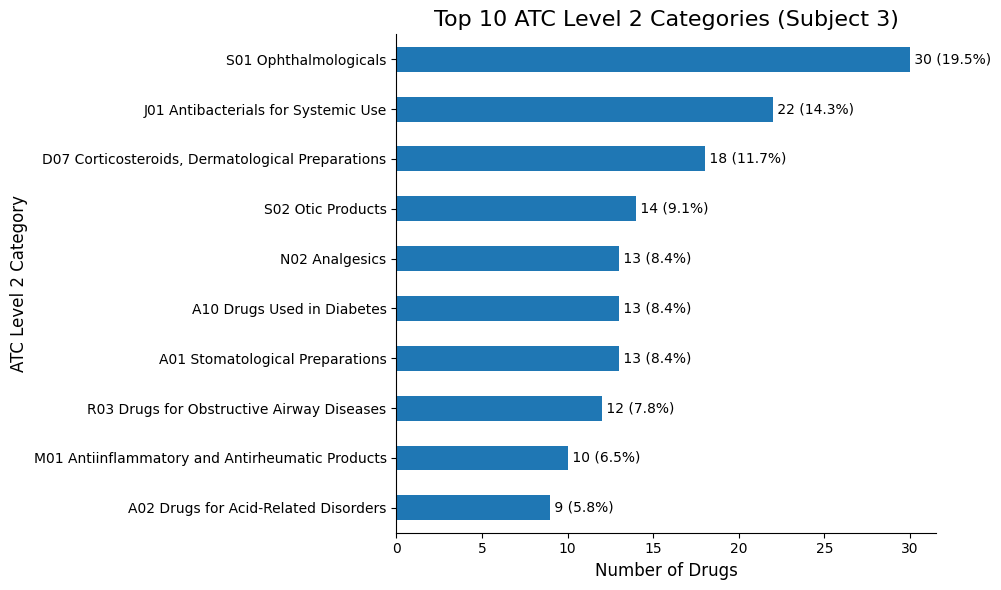

In [55]:
result = analyze_atc_codes(
    variety_208_drugs_with_info, atc_column="atc_code", top_n=10, subject=3
)

print("\nATC level 1 categories:")
print(result["level1"])
print("\nTop 10 ATC level 2 categories:")
print(result["level2"])
print("\nTop 10 ATC level 3 categories:")
print(result["level3"])
print("\nTop 10 ATC level 4 categories:")
print(result["level4"])

# Display the plots
result["figure1"].show()
result["figure2"].show()


ATC level 1 categories:
            count                                           category
atc_level1                                                          
V               3                                          V Various
P               3  P Antiparasitic Products, Insecticides and Rep...
H               6  H Systemic Hormonal Preparations, Excl. Sex Ho...
M               8                          M Musculo-Skeletal System
N              10                                   N Nervous System
G              14           G Genito Urinary System and Sex Hormones
B              14                   B Blood and Blood Forming Organs
J              20                  J Antiinfectives for Systemic Use
C              30                            C Cardiovascular System
R              51                               R Respiratory System
D              52                                  D Dermatologicals
S              60                                   S Sensory Organs
A        

/var/folders/7w/rj_0j9_94558rkgpj7x7fydh0000gn/T/ipykernel_4599/1778339329.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  result["figure1"].show()
/var/folders/7w/rj_0j9_94558rkgpj7x7fydh0000gn/T/ipykernel_4599/1778339329.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  result["figure2"].show()


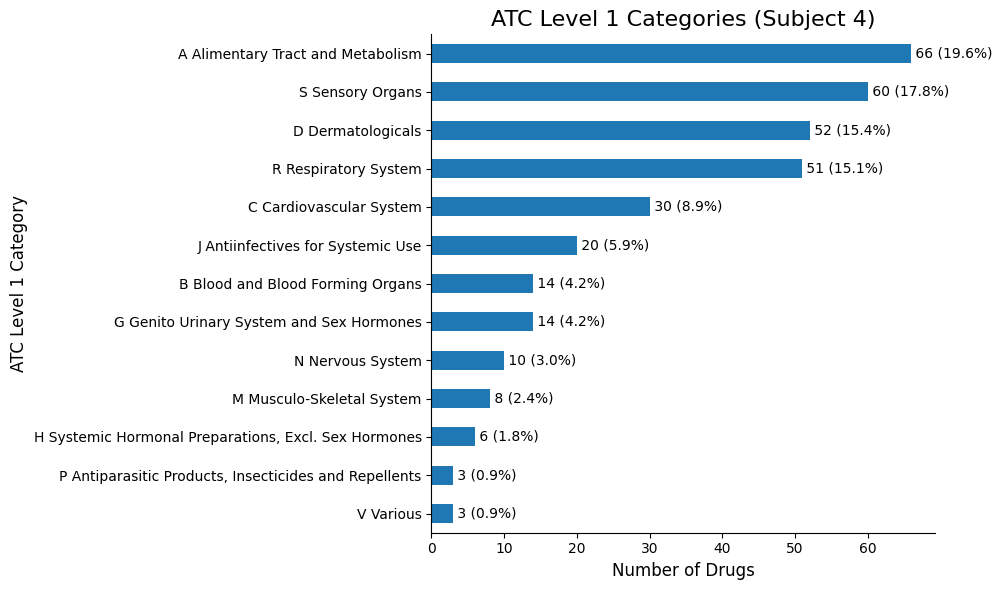

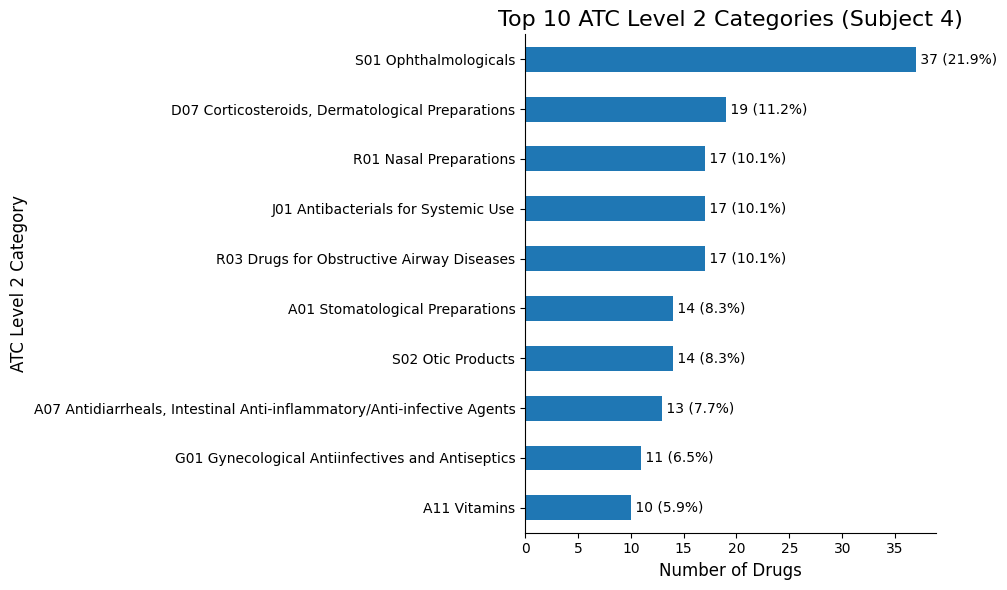

In [57]:
result = analyze_atc_codes(
    variety_202_drugs_with_info, atc_column="atc_code", top_n=10, subject=4
)

print("\nATC level 1 categories:")
print(result["level1"])
print("\nTop 10 ATC level 2 categories:")
print(result["level2"])
print("\nTop 10 ATC level 3 categories:")
print(result["level3"])
print("\nTop 10 ATC level 4 categories:")
print(result["level4"])

# Display the plots
result["figure1"].show()
result["figure2"].show()


ATC level 1 categories:
            count                                           category
atc_level1                                                          
L               1       L Antineoplastic and Immunomodulating Agents
V               3                                          V Various
P               3  P Antiparasitic Products, Insecticides and Rep...
H               5  H Systemic Hormonal Preparations, Excl. Sex Ho...
B              12                   B Blood and Blood Forming Organs
G              15           G Genito Urinary System and Sex Hormones
C              19                            C Cardiovascular System
M              19                          M Musculo-Skeletal System
N              23                                   N Nervous System
J              24                  J Antiinfectives for Systemic Use
R              34                               R Respiratory System
D              44                                  D Dermatologicals
A        

/var/folders/7w/rj_0j9_94558rkgpj7x7fydh0000gn/T/ipykernel_4599/3455106057.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  result["figure1"].show()
/var/folders/7w/rj_0j9_94558rkgpj7x7fydh0000gn/T/ipykernel_4599/3455106057.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  result["figure2"].show()


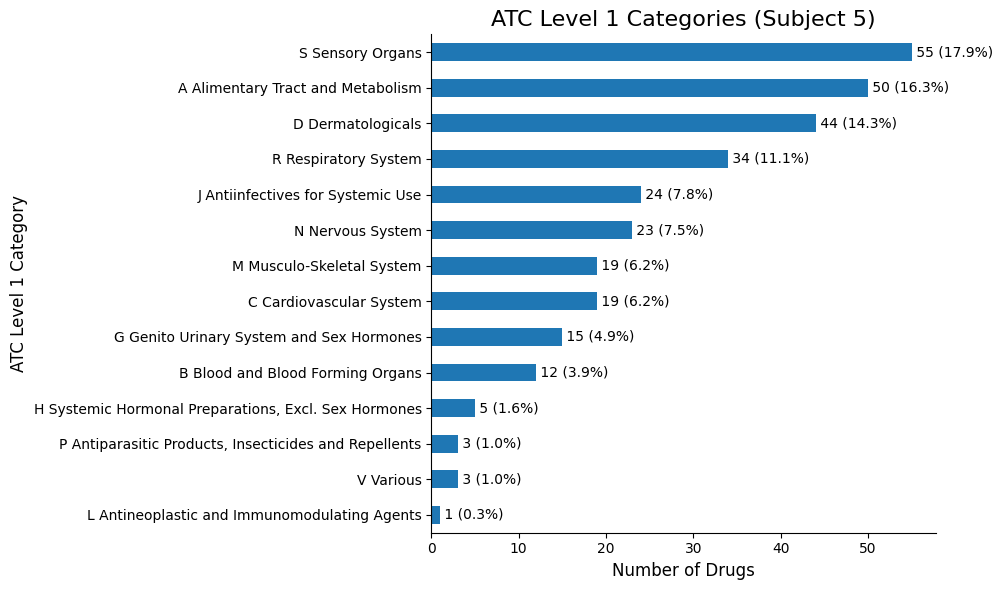

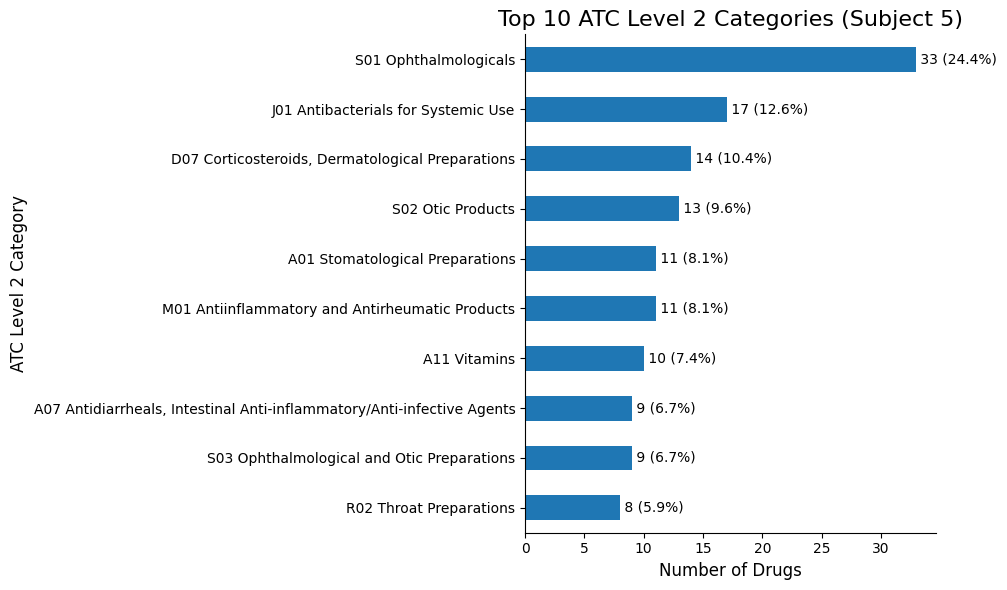

In [58]:
result = analyze_atc_codes(
    variety_201_drugs_with_info, atc_column="atc_code", top_n=10, subject=5
)

print("\nATC level 1 categories:")
print(result["level1"])
print("\nTop 10 ATC level 2 categories:")
print(result["level2"])
print("\nTop 10 ATC level 3 categories:")
print(result["level3"])
print("\nTop 10 ATC level 4 categories:")
print(result["level4"])

# Display the plots
result["figure1"].show()
result["figure2"].show()